In [448]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)


In [449]:
#Импортируем спаршенные данные
df = pd.read_excel(r"aktsii.xlsx")


В работе нам необходимо проверить, оказывает ли влияние на ROA и ROS компании пол, возраст и уровень образования генерального директора. Прежде, чем строить модель, подготовим данные, очистив выбросы и затем попробуем оценить с помощью гистограмм, как распределяются финансовые показатели фирмы в зависимости от характеристик CEO

In [450]:
#Чтобы проверить зависимость между возрастом, ROA и ROS, построим диаграмму рассеивания. Но прежде, чем сделать это,
#нам необходимо очистить данные от выбросов. Сделаем это с помощью метода квартилей.

#Формируем датафреймы ROA и ROS, которые будем анализировать. Из dfROA исключаем столбец ROS и из dfROS исключаем столбец ROA
dfROA = df.loc[:, ~df.columns.isin(["ROS"])]
dfROS = df.loc[:, ~df.columns.isin(["ROA"])]

#Очищаем датафрейм ROS от выбросов ROA
Q1_ROA = dfROA['ROA'].quantile(0.25)
Q3_ROA = dfROA['ROA'].quantile(0.75)
IQR_ROA = Q3_ROA-Q1_ROA
dfROA = dfROA[~(dfROA['ROA'] < Q1_ROA-1.5*IQR_ROA ) | (dfROA['ROA'] > Q3_ROA+1.5*IQR_ROA)]

#Очищаем датафрейм ROS от выбросов ROS
Q1_ROS = dfROS['ROS'].quantile(0.25)
Q3_ROS = dfROS['ROS'].quantile(0.75)
IQR_ROS = Q3_ROS-Q1_ROS
dfROS = dfROS[~(dfROS['ROS'] < Q1_ROS-1.5*IQR_ROS ) | (dfROS['ROS'] > Q3_ROS+1.5*IQR_ROS)]


#После удаления выбросов мы видим, что ROS имел 7 выбросов, а ROA 8 выбросов (всего в выборке 98 значений)
#Теперь можно перейти непосредственно к анализу влияния переменных на ROS и ROA
[dfROS["TICKER"].count(), dfROA["TICKER"].count()]

[91, 90]

###Анализ влияния пола директора на финансовые показатели

In [451]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у мужчин выше, чем у женщин. Однако нельзя сказать, что разница очень значительна.


#Для ROS
df_for_analyze_ROA = dfROA[["CEO's gender", "ROA"]].replace([0,1], ["Female", "Male"])
df_for_analyze_mean_ROA = df_for_analyze_ROA.groupby(["CEO's gender"]).mean()
df_for_analyze_mean_ROA.round(2)
df_for_analyze_mean_ROA["ТИП"] = "Mean"

df_for_analyze_median_ROA = df_for_analyze_ROA.groupby(["CEO's gender"]).median()
df_for_analyze_median_ROA.round(2)
df_for_analyze_median_ROA["ТИП"] = "Median"


#Аналогично для ROS
df_for_analyze_ROS = dfROS[["CEO's gender", "ROS"]].replace([0,1], ["Female", "Male"])
df_for_analyze_mean_ROS = df_for_analyze_ROS.groupby(["CEO's gender"]).mean()
df_for_analyze_mean_ROS.round(2)
df_for_analyze_mean_ROS["ТИП"] = "Mean"

df_for_analyze_median_ROS = df_for_analyze_ROS.groupby(["CEO's gender"]).median()
df_for_analyze_median_ROS.round(2)
df_for_analyze_median_ROS["ТИП"] = "Median"


pd.concat([df_for_analyze_mean_ROA, df_for_analyze_median_ROA, df_for_analyze_mean_ROS, df_for_analyze_median_ROS], axis=1)

,ROA,ТИП,ROA,ТИП,ROS,ТИП,ROS,ТИП
CEO's gender,,,,,,,,
Female,0.095964,Mean,0.038832,Median,0.117714,Mean,0.048010,Median
Male,0.100388,Mean,0.065015,Median,0.138375,Mean,0.096863,Median


<Axes: xlabel='ROS', ylabel='Count'>

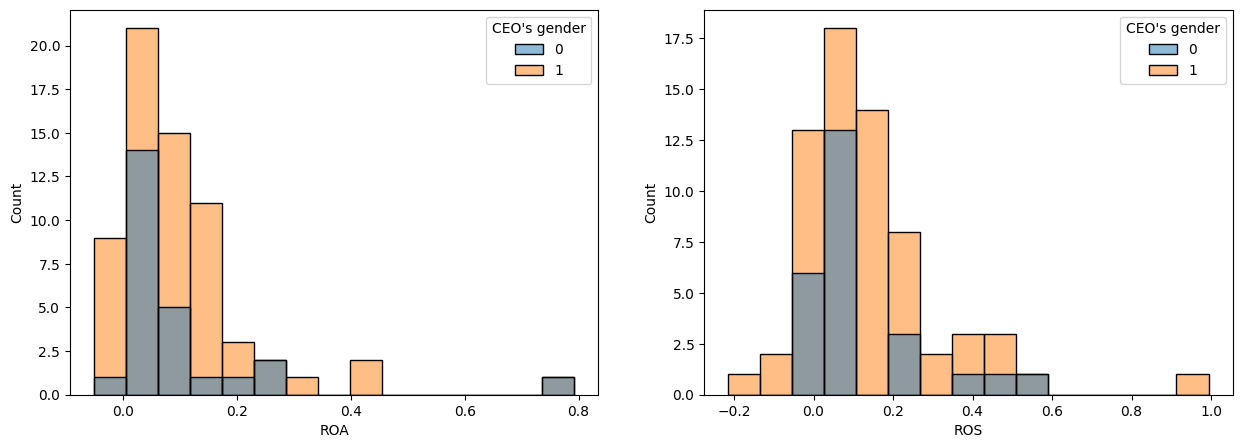

In [452]:
#Построим гистограмму распределния ROS и ROA в разрезе пола, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO женщина, 1 - мужчина. Как видим из гистограммы, большинство значений сконцентрировались ближе к середине.
#к области медианных и средних значений за исключением отдельных выбросов. В абсолютном выражении все компании
#сконцентрировались в области от -0.2 до 0.2 для ROA и -0.5 до 0.5 для ROS. Явного полового перекоса в выбросах выше
#выше или ниже средних и медианных значений для общей выборки по рынку не наблюдается.

f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(dfROA, x = "ROA", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(dfROS, x = "ROS", bins=15, hue= """CEO's gender""",  ax=axes[1])

<Axes: >

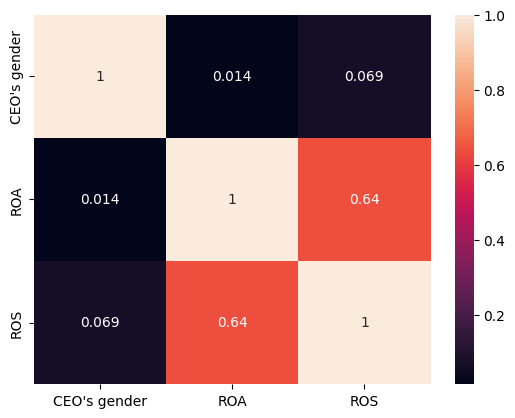

In [453]:
#Проведём последний тест корреляции между половым распределением и ROA/ROS. Как видим, корреляция фактически отсутствует.
#Мы не будем включать переменную пола в итоговое уравнение регрессии.

corrROA = dfROA[["CEO's gender", "ROA"]]
corrROS = dfROS[["ROS"]]
corr = pd.concat([corrROA,corrROS], axis = 1)
sns.heatmap(corr.corr(), annot=True)

###Анализ влияния национальности директора на финансовые показатели

In [454]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у генеральных директоров-россиян выше, чем у иностранцев. Причём разница довольно значительна.


#Для ROS
df_for_analyze_ROA = dfROA[["CEO's nationality", "ROA"]].replace([0,1], ["Иностранец", "Русский"])
df_for_analyze_mean_ROA = df_for_analyze_ROA.groupby(["CEO's nationality"]).mean()
df_for_analyze_mean_ROA.round(2)
df_for_analyze_mean_ROA["ТИП"] = "Mean"

df_for_analyze_median_ROA = df_for_analyze_ROA.groupby(["CEO's nationality"]).median()
df_for_analyze_median_ROA.round(2)
df_for_analyze_median_ROA["ТИП"] = "Median"


#Аналогично для ROS
df_for_analyze_ROS = dfROS[["CEO's nationality", "ROS"]].replace([0,1], ["Иностранец", "Русский"])
df_for_analyze_mean_ROS = df_for_analyze_ROS.groupby(["CEO's nationality"]).mean()
df_for_analyze_mean_ROS.round(2)
df_for_analyze_mean_ROS["ТИП"] = "Mean"

df_for_analyze_median_ROS = df_for_analyze_ROS.groupby(["CEO's nationality"]).median()
df_for_analyze_median_ROS.round(2)
df_for_analyze_median_ROS["ТИП"] = "Median"


pd.concat([df_for_analyze_mean_ROA, df_for_analyze_median_ROA, df_for_analyze_mean_ROS, df_for_analyze_median_ROS], axis=1)

,ROA,ТИП,ROA,ТИП,ROS,ТИП,ROS,ТИП
CEO's nationality,,,,,,,,
Иностранец,0.026092,Mean,0.021442,Median,0.026791,Mean,0.011876,Median
Русский,0.111495,Mean,0.065074,Median,0.150351,Mean,0.093475,Median


<Axes: xlabel='ROS', ylabel='Count'>

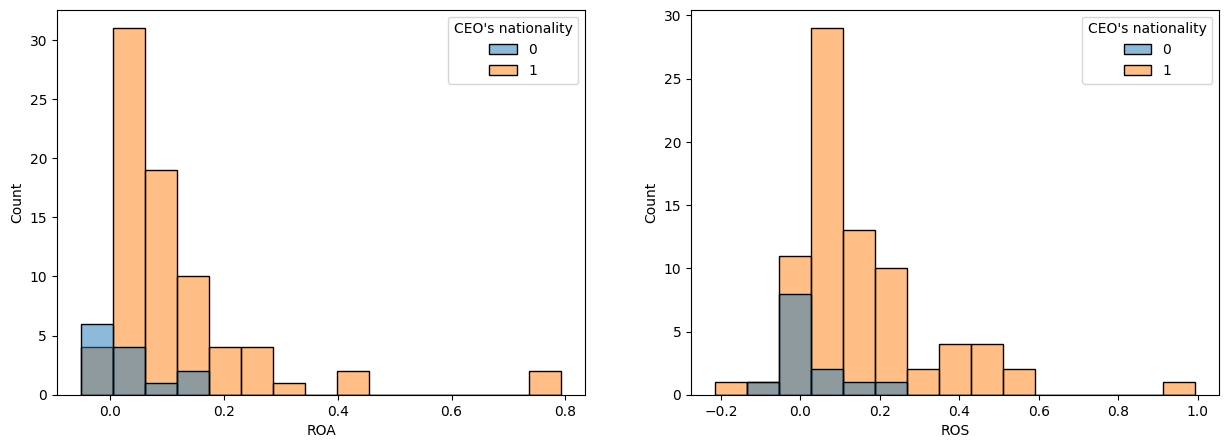

In [455]:
#Построим гистограмму распределния ROS и ROA в разрезе национальности, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO россиянин, 1 - иностранец. Как видим из гистограммы, практически во всех группах ROA и ROS больше CEO-россиян.
#Это объясняется довольно просто - как правило генеральные директора в российских компаниях - это россияне, поэтому
#едва ли гистограмма поможет нам в проверке гипотезы о значимости переменной национальности. Тем не менее,
#даже в такой ситуации видно, что те компании, где генеральные директора иностранцы чаще превалируют в группах с ROS и ROA ниже
#среднего по рынку.


f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(dfROA, x = "ROA", bins=15, hue= """CEO's nationality""", ax=axes[0])
sns.histplot(dfROS, x = "ROS", bins=15, hue= """CEO's nationality""",  ax=axes[1])

<Axes: >

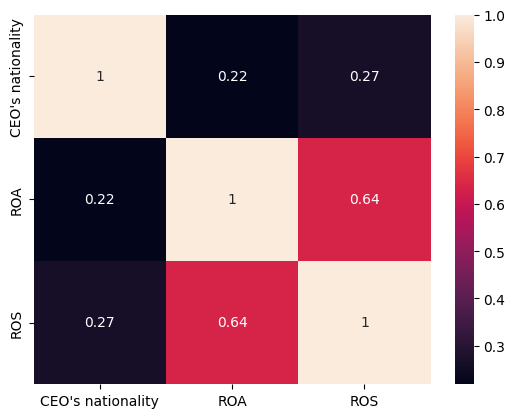

In [456]:
#Проведём последний тест корреляции между национальностью и ROA/ROS. Как видим, корреляция есть, хоть и слабая.
#На контрасте со значениями корреляции по полу эту переменную следует включить в уравнение регрессии и проверить её значимость
#На других тестах уже при работе с самим уравнением в будущем.

corrROA = dfROA[["CEO's nationality", "ROA"]]
corrROS = dfROS[["ROS"]]
corr = pd.concat([corrROA,corrROS], axis = 1)
sns.heatmap(corr.corr(), annot=True)

###Проверка влияния возраста директора на финансовые показатели

<Axes: >

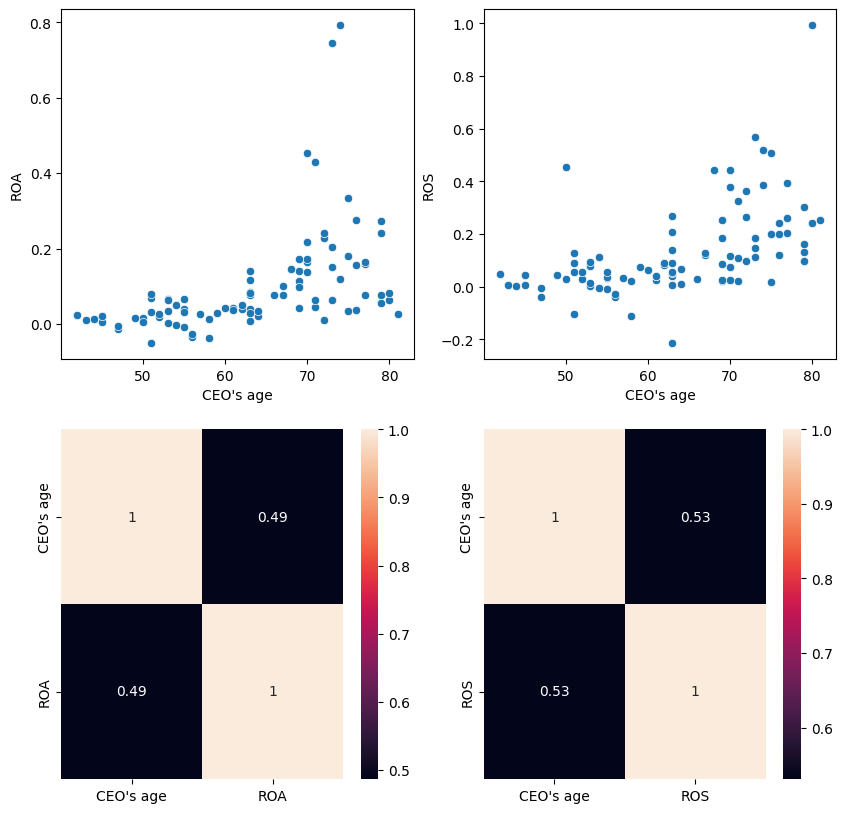

In [457]:
#Теперь построим диаграммы рассеивания на основе полученных данных. Как видим, наблюдается довольно очевидная прямая зависимость
#Чем выше возраст директора, тем лучшие финансовые показатели у фирмы. Подтвердим нашу гипотезу также корреляционным анализом.
#Что и требовалось ожидать - есть среднеумеренная связь между показателями возраста директора и финансовыми результатами.


f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(dfROA[["CEO's age", "ROA"]], x = "CEO's age", y = "ROA", ax=axes[0,0])
sns.scatterplot(dfROS[["CEO's age", "ROS"]], x = "CEO's age", y = "ROS",ax=axes[0,1])

sns.heatmap(dfROA[["CEO's age", "ROA"]].corr(), annot=True, ax=axes[1,0])
sns.heatmap(dfROS[["CEO's age", "ROS"]].corr(), annot=True, ax=axes[1,1])




###Проверка влияния уровня образования директора на финансовые результаты компании

<Axes: >

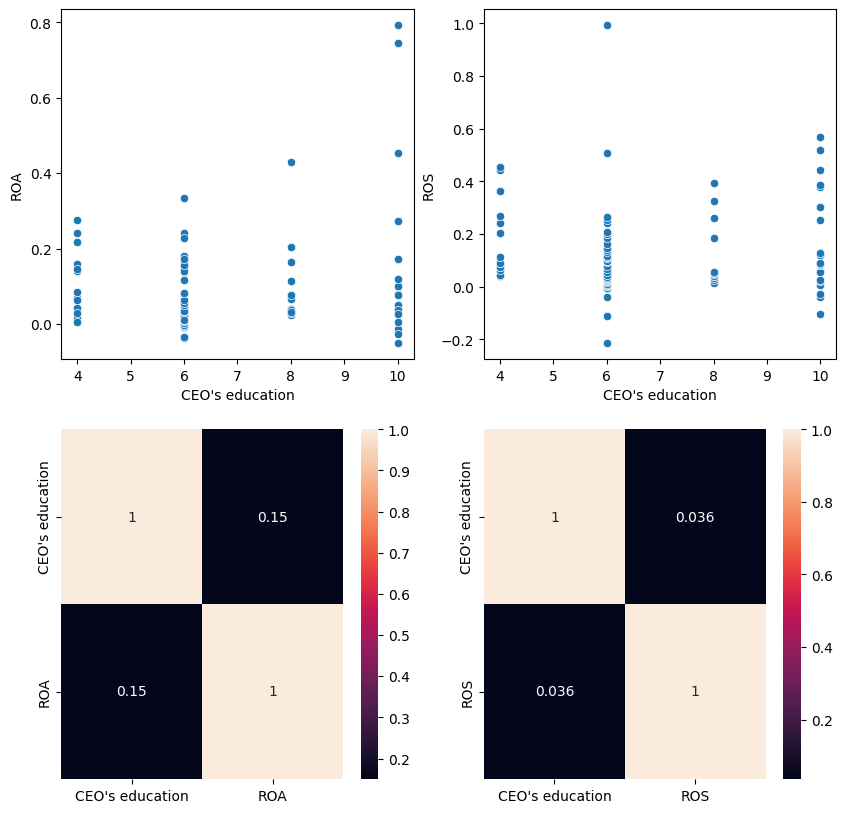

In [458]:
#Построим диаграммы рассеивания и корреляционные матрицы уровня образования. Обе диаграммы показали довольно хаотичную связь:
#нельзя точно увидеть какой-то тренд между уровнем образования и финансовыми показателями. При этом корреляционный анализ
#Тоже дал неоднозначные результаты - между уровнем образования и ROA наблюдается слабая связь со стремлением к средней.
#В то же время между ROS и уровнем образования связь не наблюдается вообще. Возможно, связь между ROA и уровнем образования
#можно объяснить тем, что директоров с несколькими высшими (8 - 10 лет обучения) чаще берут на работу именно крупные компании
#и назначают на высокие должности. Но при этом не факт, что такие директора будут генерировать прибыль, что объясняет
#отсутствие связи между образованием и ROS. Не будем включать эту переменную в уравнение регрессии.

f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(dfROA[["CEO's education", "ROA"]], x = "CEO's education", y = "ROA", ax=axes[0,0])
sns.scatterplot(dfROS[["CEO's education", "ROS"]], x = "CEO's education", y = "ROS",ax=axes[0,1])

sns.heatmap(dfROA[["CEO's education", "ROA"]].corr(), annot=True, ax=axes[1,0])
sns.heatmap(dfROS[["CEO's education", "ROS"]].corr(), annot=True, ax=axes[1,1])




В результате анализа переменных мы обнаружили две потенциально влияющие переменные - возраст и национальность генерального директора. При этом в статистике остались еще переменные, которые могут повлиять на финансовые результаты компании.
Построим корреляционные матрицы по оставшимся данным и отберем те, где будет наблюдаться хотя бы слабая связь (больше 0.2 по шкале Чеддока) между влияющими и зависимыми переменными. Но перед этим сгладим данные методом кубического корня с целью уменьшить экспрессию переменных.

<Axes: >

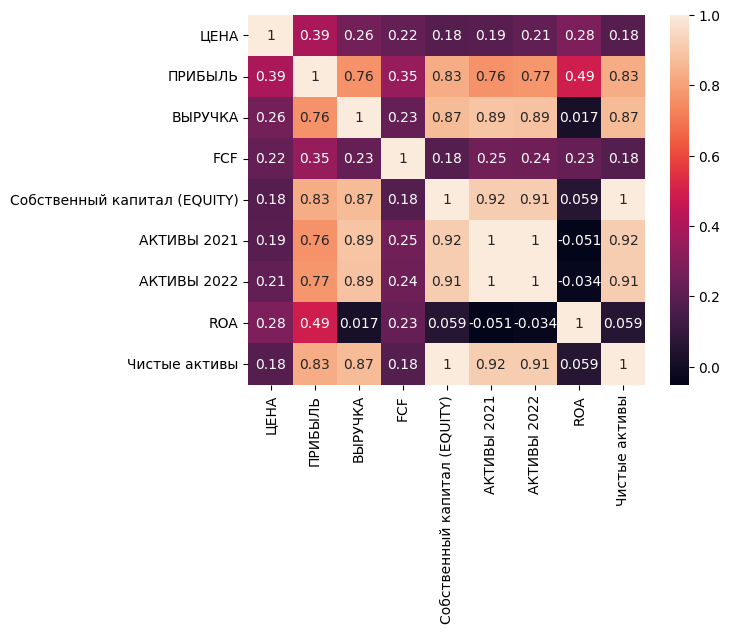

In [459]:

#Отбираем данные, которые нужно нормализовать и для которых нужно проверить корреляцию с целевыми переменными. 
dfNormROA = dfROA.loc[:, ~dfROA.columns.isin(['TICKER'])]
#Сглаживаем данные с помощью логарифма
dfNormROA = np.cbrt(dfNormROA)

#Отбрасываем лишние для матрицы столбцы
corrROS= dfNormROA.loc[:, ~dfNormROA.columns.isin(["CEO's gender", "CEO's age", "CEO's nationality", "CEO's education"])]
sns.heatmap(corrROS.corr(), annot=True)

<Axes: >

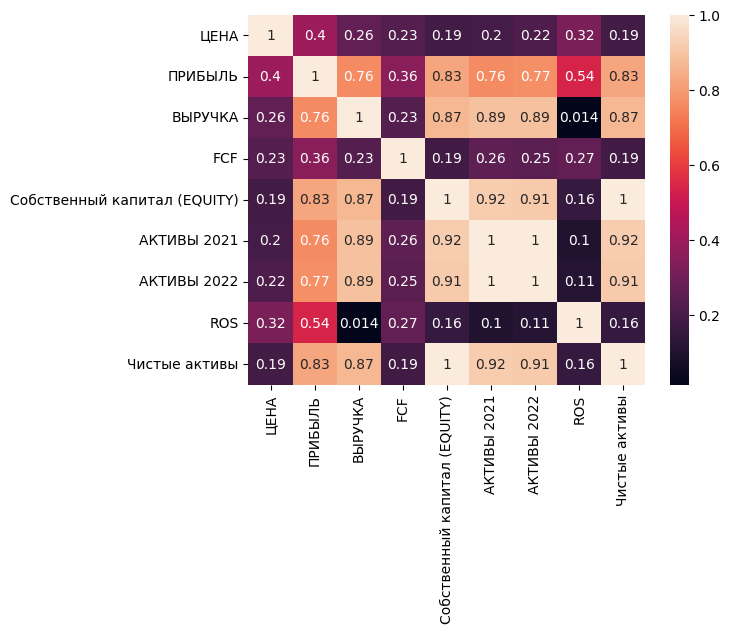

In [460]:
#Отбираем данные, которые нужно нормализовать и для которых нужно проверить корреляцию с целевыми переменными. 
dfNormROS = dfROS.loc[:, ~dfROS.columns.isin(['TICKER', "CEO's gender", "CEO's age", "CEO's nationality", "CEO's education"])]
#Сглаживаем данные с помощью логарифма
dfNormROS = np.cbrt(dfNormROS)

#Отбрасываем лишние для матрицы столбцы
corrROS= dfNormROS.loc[:, ~dfNormROS.columns.isin(["CEO's gender", "CEO's age", "CEO's nationality", "CEO's education"])]
sns.heatmap(corrROS.corr(), annot=True)

In [461]:
dfNormROS

,ЦЕНА,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROS,Чистые активы
6,1.644826,-1368.158857,2284.521141,-1436.780358,1515.977360,2414.152492,2643.737437,-0.598882,1515.977360
7,1.071441,-873.879273,1816.848994,-466.123234,1858.150935,2515.007174,2741.122757,-0.480986,1858.150935
8,7.973349,-660.385450,1409.627519,-763.460672,1308.815821,1727.019269,1825.161054,-0.468482,1308.815821
9,8.329954,-1575.405120,4606.826663,-1981.750654,5519.074269,6677.469430,7119.808468,-0.341972,5519.074269
10,2.233375,-366.278745,1100.014049,628.716628,921.335882,1173.051668,1048.262281,-0.332976,921.335882
11,5.654569,-2175.696698,7383.148897,-1316.361267,1854.699520,7588.081504,6938.169754,-0.294684,1854.699520
12,0.383948,-778.318754,4057.518665,-1139.747302,3392.533037,4017.233706,4073.850750,-0.191821,3392.533037
13,0.454603,-637.385985,3763.535277,895.051858,2592.595055,3680.640789,3800.921799,-0.169358,2592.595055
14,0.878503,-571.435798,4015.600018,1130.215585,2609.171211,4248.093466,4345.431095,-0.142304,2609.171211
15,3.141718,622.764279,5869.116861,1850.401471,2379.060194,4745.188450,4835.266158,0.106109,2379.060194


Итого мы получили уравнения регрессии для прогнозирования ROA и ROS:

ROA = a0 + a1 * Цена + a2 * ПРИБЫЛЬ + a3 * FCF + a4 * АКТИВЫ 2021 + a5 * АКТИВЫ 2022 + error

ROS = b0 + b1 * Цена + b2 * ПРИБЫЛЬ + b3 * FCF + b4 * Equity + a5 * Чистые активы + error

In [462]:
#Перейдём к построению моделей. Для этого импортируем эконометрические библиотеки и подготовим датафрейм на нормализованных данных

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy



In [463]:
dfNormROA

,ЦЕНА,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,Чистые активы,CEO's gender,CEO's age,CEO's nationality,CEO's education
7,1.071441,-873.879273,1816.848994,-466.123234,1858.150935,2515.007174,2741.122757,-0.331905,1858.150935,1.0,3.870877,1.0,1.817121
8,7.973349,-660.385450,1409.627519,-763.460672,1308.815821,1727.019269,1825.161054,-0.371536,1308.815821,1.0,3.708430,0.0,2.154435
9,8.329954,-1575.405120,4606.826663,-1981.750654,5519.074269,6677.469430,7119.808468,-0.228130,5519.074269,1.0,3.608826,0.0,2.154435
10,2.233375,-366.278745,1100.014049,628.716628,921.335882,1173.051668,1048.262281,-0.328751,921.335882,1.0,3.825862,0.0,1.817121
11,5.654569,-2175.696698,7383.148897,-1316.361267,1854.699520,7588.081504,6938.169754,-0.298957,1854.699520,1.0,3.825862,0.0,2.154435
12,0.383948,-778.318754,4057.518665,-1139.747302,3392.533037,4017.233706,4073.850750,-0.192380,3392.533037,1.0,3.802952,0.0,1.817121
13,0.454603,-637.385985,3763.535277,895.051858,2592.595055,3680.640789,3800.921799,-0.170344,2592.595055,1.0,3.608826,1.0,1.817121
14,0.878503,-571.435798,4015.600018,1130.215585,2609.171211,4248.093466,4345.431095,-0.132975,2609.171211,1.0,3.779763,1.0,1.817121
15,3.141718,622.764279,5869.116861,1850.401471,2379.060194,4745.188450,4835.266158,0.129996,2379.060194,1.0,3.756286,0.0,1.817121
16,3.057413,459.125623,2937.379891,415.804796,1068.595706,1889.428828,1874.551810,0.243954,1068.595706,1.0,3.530348,1.0,1.817121


###Построение и анализ модели ROA

In [464]:
#Модель ROA

y = dfNormROA["ROA"]
x = dfNormROA[["ЦЕНА", "ПРИБЫЛЬ", "FCF", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

results = sm.OLS(y, x).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     20.72
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           2.00e-13
Time:                        16:57:42   Log-Likelihood:                 34.749
No. Observations:                  90   AIC:                            -57.50
Df Residuals:                      84   BIC:                            -42.50
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8735      0.330     -5.670      0.000      -2.531      -1.216
ЦЕНА                  0.0036      0.004      0.996      0.322      -0.004       0.011
ПРИБЫЛЬ            4.078e-05   1.15e-05      3.538      0.001    1.79e-05    6.37e-05
FCF               -6.035e-07   8.23e-06     -0.073      0.942    -1.7e-05    1.58e-05
CEO's age             0.4985      0.085      5.845      0.000       0.329       0.668
CEO's nationality     0.1892      0.053      3.558      0.001       0.083       0.295
==============================================================================
Omnibus:                        5.054   Durbin-Watson:                   1.376
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                6.098
Skew:                          -0.211   Prob(JB):                       0.0474
Kurtosis:                       4.203   Cond. No.                     5.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Прежде, чем перейти к анализу модели на точность, нам следует проверить, не допустили ли мы стандартные ошибки при построении регрессии, а именно:

- Включение в модель незначимых переменных
- Неправильно подобранная функция регрессии
- Невключение важных регрессоров модель

Кроме того, эконометристы часто проверяют данные на ошибку четвертого рода, а именно на автокорреляцию остатков с помощью теста Чоу. В нашем случае это делать нецелесообразно, так как данные пространственные и не являются временными рядами.

In [465]:
#Проверка на ошибку первого рода - незначимые переменные.
#Для проверки нам необходимо сравнить коэффицент t регрессора (отношение коэффициента к std err) к t критическому при 
#alfa = 0.1 и степенях свободы n-k = 97 - 5 = 92

t_crit = scipy.stats.t.ppf(1-0.1/2, 92)
t_crit

#t критическое равно 1.661. Переменные ЦЕНА и ПРИБЫЛЬ имеют t ниже t критического. Исключим эти переменные из модели как незначимые
#И повторим тест



1.6615853968734788

In [466]:
#Модель ROA

y = df["ROA"]
x = df[["CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     19.82
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           6.59e-08
Time:                        16:57:42   Log-Likelihood:                 60.428
No. Observations:                  97   AIC:                            -114.9
Df Residuals:                      94   BIC:                            -107.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4289      0.083     -5.196      0.000      -0.593      -0.265
CEO's age             0.0071      0.001      5.401      0.000       0.004       0.010
CEO's nationality     0.0697      0.037      1.879      0.063      -0.004       0.143
==============================================================================
Omnibus:                       60.227   Durbin-Watson:                   1.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.472
Skew:                           1.920   Prob(JB):                     1.93e-74
Kurtosis:                      11.321   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Теперь проверим модель на ошибку первого рода, а именно на правильно подобранную функцию регрессии. Для этого нам нужно оценить знаки случайных остатков и коэффициенты двух моделей из разбитыХ поровну выборок.

In [467]:
residuals_test = pd.DataFrame(y, columns = ["ROA"])
residuals_test["const"] = results.params["const"]

residuals_test["CEO's age coef"] =results.params["CEO's age"]
residuals_test["CEO's age"] =x["CEO\'s age"]

residuals_test["CEO's nationality coef"] =results.params["CEO's nationality"]
residuals_test["CEO's nationality"] =x["CEO's nationality"]

residuals_test["residuals"] = residuals_test["ROA"]-residuals_test["const"]-residuals_test["CEO's age coef"]*residuals_test["CEO's age"]\
-residuals_test["CEO's nationality coef"]*residuals_test["CEO's nationality"]

#residuals_test

Для начала посмотрим на случайные остатки. Расположим модули регрессоров по возрастанию и посмотрим на знаки. В целом знаки остатков не задерживаются на одном месте и постоянно меняются. Можем говорить о том, что остатки действительно случайные.

In [468]:
residuals_test["Regressors_Modules"] = abs(residuals_test["CEO's age"]+residuals_test["CEO's nationality"])
residuals_test.sort_values(by = "Regressors_Modules")

,ROA,const,CEO's age coef,CEO's age,CEO's nationality coef,CEO's nationality,residuals,Regressors_Modules
0,-0.168625,-0.428894,0.007116,42,0.06972,1,-0.108303,43
40,0.022744,-0.428894,0.007116,42,0.06972,1,0.083066,43
18,0.010454,-0.428894,0.007116,43,0.06972,1,0.063660,44
16,0.014519,-0.428894,0.007116,44,0.06972,1,0.060609,45
39,0.020090,-0.428894,0.007116,45,0.06972,1,0.059065,46
19,0.004169,-0.428894,0.007116,45,0.06972,1,0.043145,46
9,-0.011873,-0.428894,0.007116,47,0.06972,0,0.082592,47
13,-0.004943,-0.428894,0.007116,47,0.06972,1,0.019801,48
38,0.016421,-0.428894,0.007116,49,0.06972,1,0.026934,50
30,0.017070,-0.428894,0.007116,50,0.06972,1,0.020468,51


Оценим коэффициенты двух моделей. Разделим выборку на две части: с 1-ого наблюдения по 48-е и с 49-ого по 97-ое.

In [469]:
#Первая половина
y1 = y[0:48]
x1 = x[0:48]
x1 = sm.add_constant(x1)
results1 = sm.OLS(y1, x1).fit()

#Вторая половина
y2 = y[49:97]
x2 = x[49:97]
x2 = sm.add_constant(x2)
results2 = sm.OLS(y2, x2).fit()


In [470]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.756
Date:                Wed, 03 Jan 2024   Prob (F-statistic):              0.184
Time:                        16:57:42   Log-Likelihood:                 21.695
No. Observations:                  48   AIC:                            -37.39
Df Residuals:                      45   BIC:                            -31.78
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1902      0.200     -0.950      0.347      -0.593       0.213
CEO's age             0.0053      0.003      1.811      0.077      -0.001       0.011
CEO's nationality    -0.0137      0.121     -0.113      0.910      -0.258       0.230
==============================================================================
Omnibus:                       41.540   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.777
Skew:                           2.372   Prob(JB):                     1.09e-28
Kurtosis:                       9.472   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [471]:
testDF1 = pd.DataFrame(results1.params, columns = ["Регрессор 1"])
testDF2 = pd.DataFrame(results2.params, columns = ["Регрессор 2"])
testDF = pd.concat([testDF1,testDF2], axis=1)
testDF

,Регрессор 1,Регрессор 2
const,-0.246009,-0.190172
CEO's age,0.003605,0.005259
CEO's nationality,0.050143,-0.013730


In [472]:
80*0.005259+1*-0.013730+-0.190172	

0.21681799999999996

Как мы видим, оценки коэффициентов мало отличаются друг от друга при разделении выборок на две равные части.